In [25]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as colors
from metpy.calc import saturation_mixing_ratio
from metpy.units import units
from src.project_configs import *
from src.plotting import *
from src.buoyancy import *
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# W and circulation

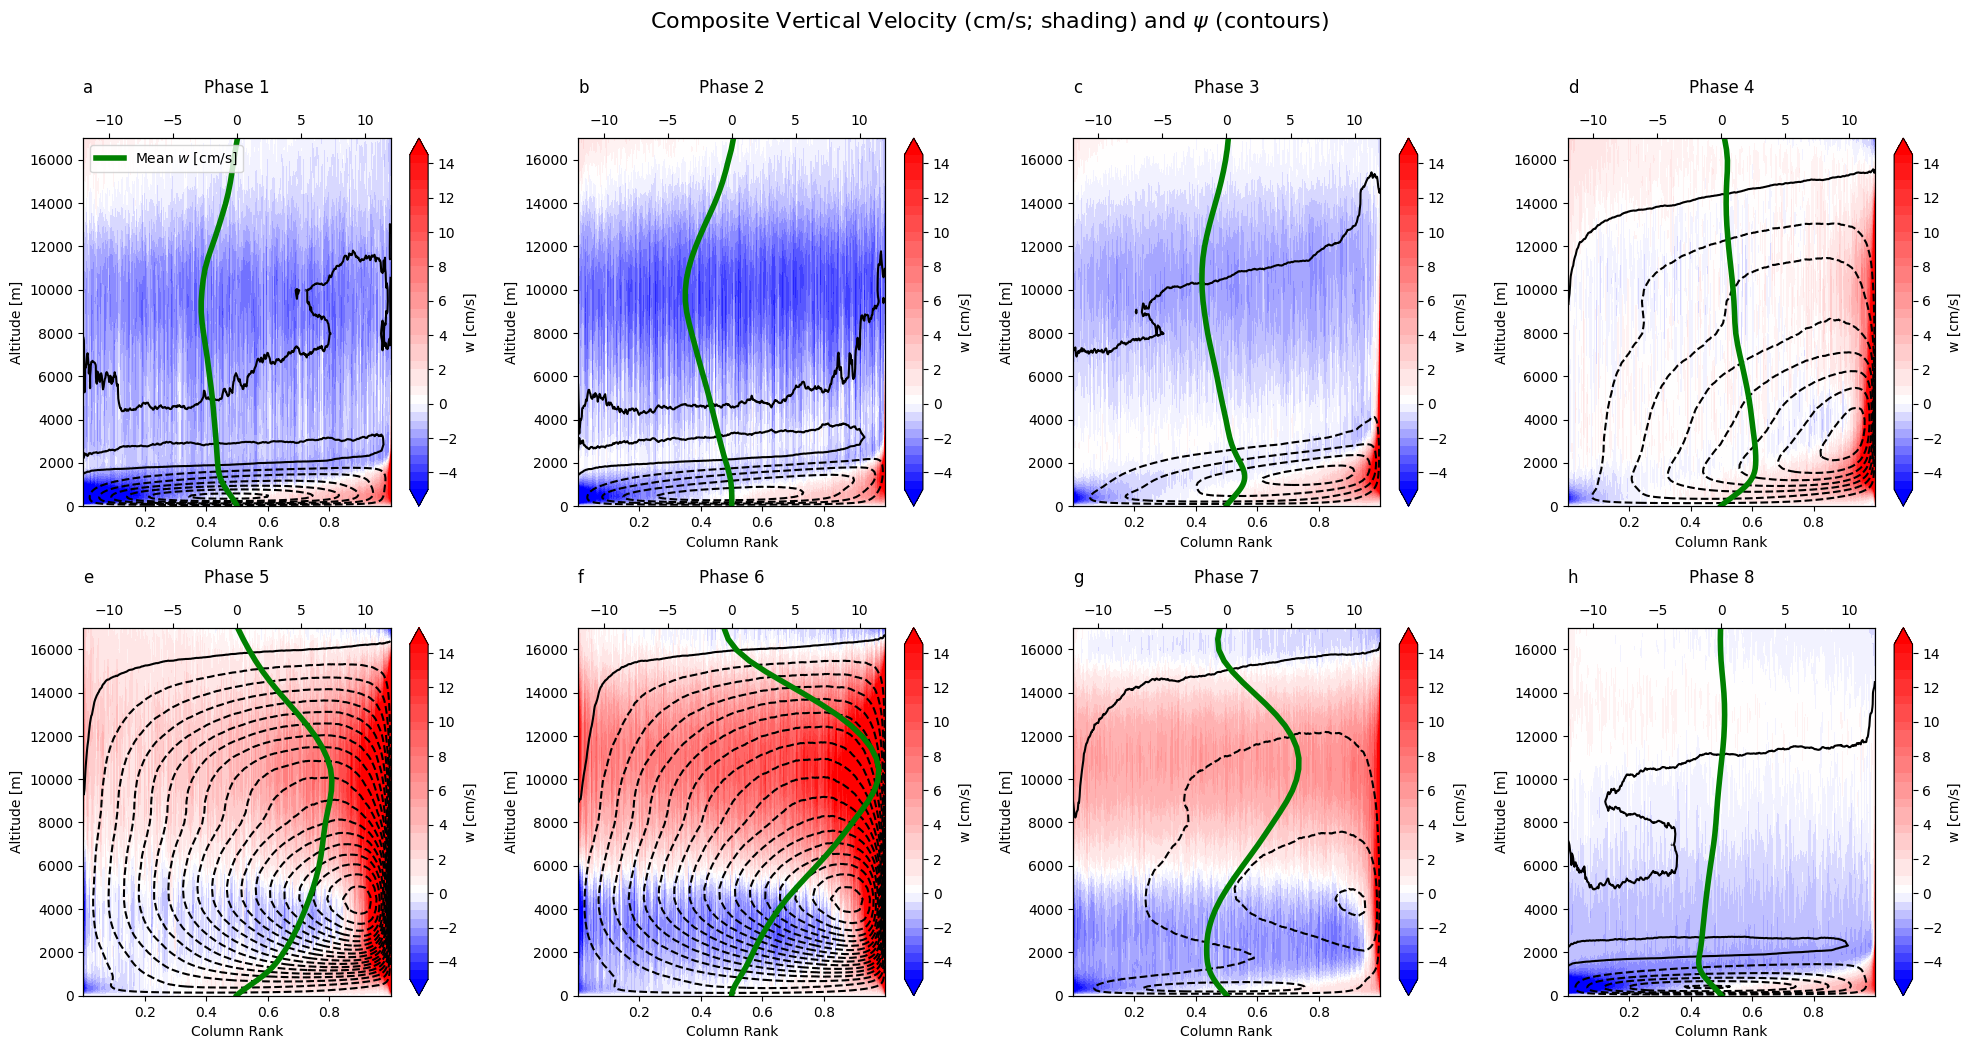

In [104]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
for i in range(1,9):
    ax = axs[np.unravel_index(i-1, axs.shape)]

    # w plots
    w = load_phase_composite('W', i).W*100
    w = w.coarsen({'column': 5}).mean()
    levels = np.arange(-5, 15, 0.5)
    w.plot.contourf(ax=ax,
                    levels=levels,
                    cmap=plt.cm.bwr.copy(),
                    norm=colors.TwoSlopeNorm(vcenter=0, vmin=levels.min(), vmax=levels.max()),
                    cbar_kwargs={'label': 'w [cm/s]'})

    # Plot mean W
    ax2 = ax.twiny()
    w.mean('column').plot(ax=ax2, y='z', color='green', lw=4, label=r'Mean $w$ [cm/s]')
    ax2.set_xlim(-12, 12)
    ax2.set_xlabel(None)
    if i==1:
        ax2.legend(loc='upper left')
    # circulation plots
    circ = load_phase_composite('circulation', i).W
    circ = circ.assign_coords({'column': np.linspace(0, 1, circ.column.size)})
    circ = circ.coarsen({'column': 5}).mean()
    # levels = np.linspace(-150, 0, 20)
    levels = np.linspace(-150, 0, 20)
    circ.plot.contour(ax=ax, levels=levels, colors='black')

    ax.set_ylim(0, 17e3)
    ax.set_title(f'Phase {i}', y=1.1)
    ax.set_title(chr(ord('a') + (i-1)), loc='left', y=1.1)
    ax.set_ylabel('Altitude [m]')
    ax.set_xlabel('Column Rank')
fig.tight_layout(pad=1.5)
fig.suptitle(r'Composite Vertical Velocity (cm/s; shading) and $\psi$ (contours)', y=1.05, fontsize=16)
save_figure(fig, 'phase_composites_psi_w_mean.pdf')

# MSE

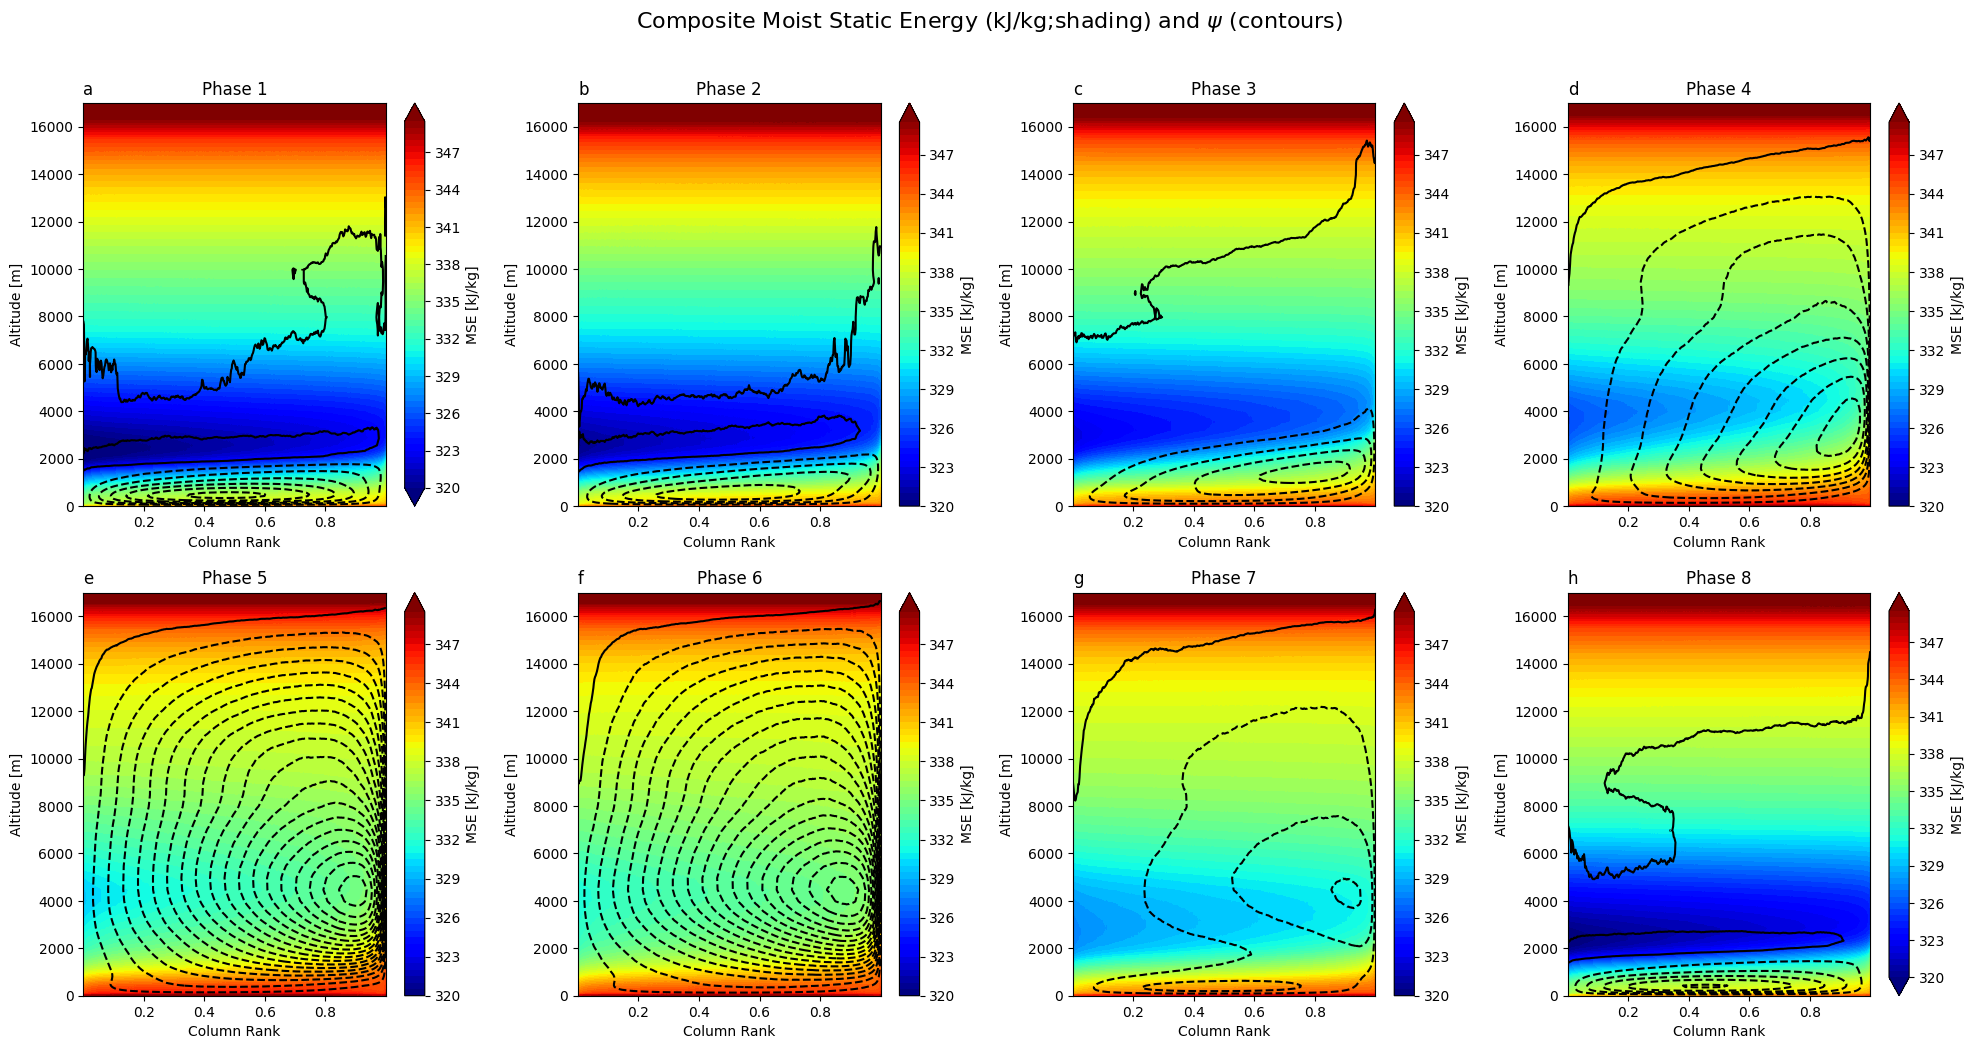

In [105]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
for i in range(1,9):
    ax = axs[np.unravel_index(i-1, axs.shape)]

   
    # MSE plots
    qv = load_phase_composite('QV', i).QV * 1e-3 # convert to kg/kg
    T = load_phase_composite('TABS', i).TABS
    Lqv_plus_cpT = (2.5e6*qv) + (1004*T)
    MSE = Lqv_plus_cpT + (9.81*Lqv_plus_cpT.z)
    MSE = MSE / 1000 # convert to kJ
    MSE = MSE.coarsen({'column': 5}).mean()
    levels = np.arange(320, 350, 0.5)
    MSE.plot.contourf(ax=ax,
                      levels=levels,
                      cmap=plt.cm.jet.copy(),
                      norm=colors.Normalize(vmin=levels.min(), vmax=levels.max()), 
                      cbar_kwargs={'label': 'MSE [kJ/kg]'})

    
    # circulation plots
    circ = load_phase_composite('circulation', i).W
    circ = circ.assign_coords({'column': np.linspace(0, 1, circ.column.size)})
    circ = circ.coarsen({'column': 5}).mean()
    levels = np.linspace(-150, 0, 20)
    circ.plot.contour(ax=ax, levels=levels, colors='black')

    
    ax.set_ylim(0, 17e3)
    ax.set_title(f'Phase {i}')
    ax.set_title(chr(ord('a') + (i-1)), loc='left')
    ax.set_ylabel('Altitude [m]')
    ax.set_xlabel('Column Rank')
fig.tight_layout(pad=1.5)
fig.suptitle(r'Composite Moist Static Energy (kJ/kg;shading) and $\psi$ (contours)', y=1.05, fontsize=16)
save_figure(fig, 'phase_composites_psi_mse.pdf')

# Radiative cooling

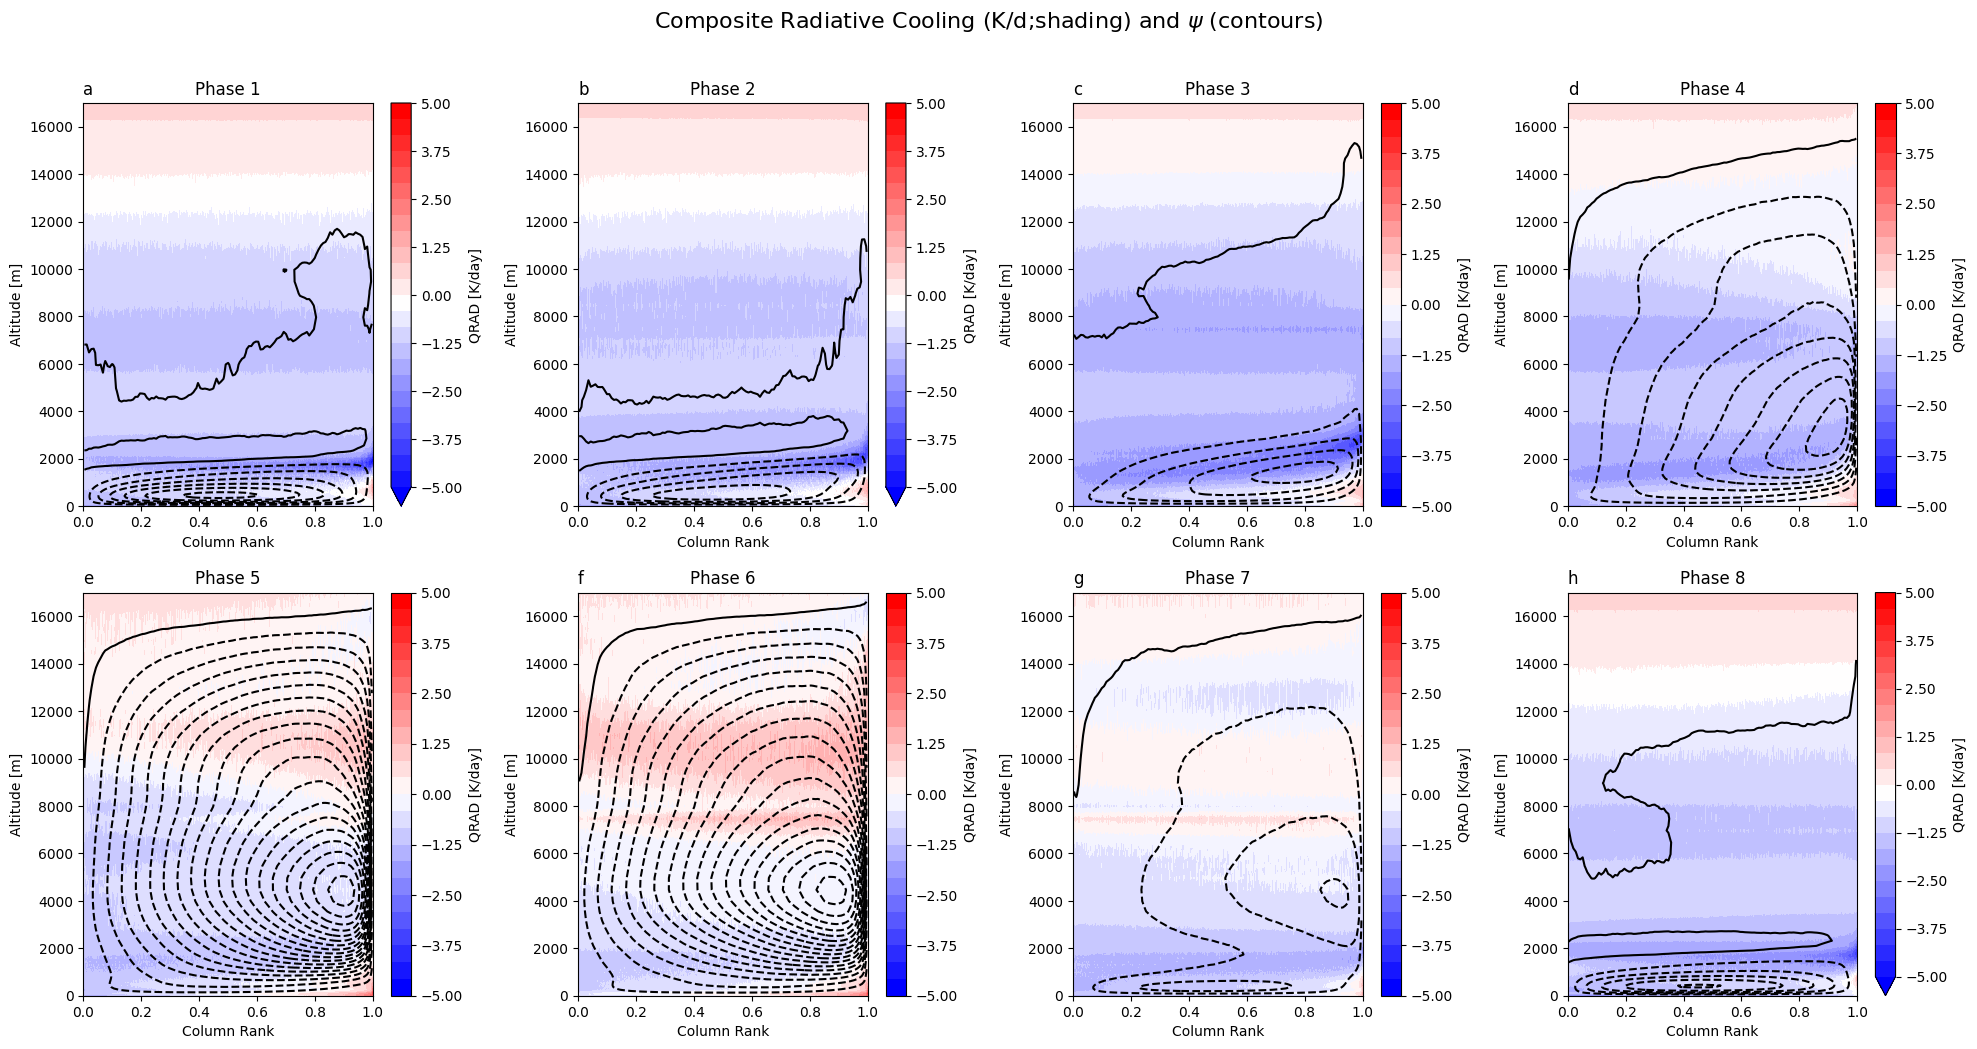

In [106]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
for i in range(1,9):
    ax = axs[np.unravel_index(i-1, axs.shape)]

   
    # QCpI plots
    qrad = load_phase_composite('QRAD', i).QRAD
    levels = np.linspace(-5, 5, 25)
    cmap = plt.cm.bwr.copy()
    qrad.plot.contourf(ax=ax,
                      levels=levels,
                      cmap=cmap,
                      norm=colors.TwoSlopeNorm(vcenter=0, vmin=levels.min(), vmax=levels.max()),
                      cbar_kwargs={'label': 'QRAD [K/day]'})

    cb = fig.colorbar

    # circulation plots
    circ = load_phase_composite('circulation', i).W
    circ = circ.assign_coords({'column': np.linspace(0, 1, circ.column.size)})
    circ = circ.coarsen({'column': 20}).mean()
    levels = np.linspace(-150, 0, 20)
    circ.plot.contour(ax=ax, levels=levels, colors='black')

    ax.set_ylim(0, 17e3)
    ax.set_title(f'Phase {i}')
    ax.set_title(chr(ord('a') + (i-1)), loc='left')
    ax.set_ylabel('Altitude [m]')
    ax.set_xlabel('Column Rank')
fig.tight_layout(pad=1.5)
fig.suptitle(r'Composite Radiative Cooling (K/d;shading) and $\psi$ (contours)', y=1.05, fontsize=16)
save_figure(fig, 'phase_composites_psi_qrad.pdf')

# Cloud Mixing ratio

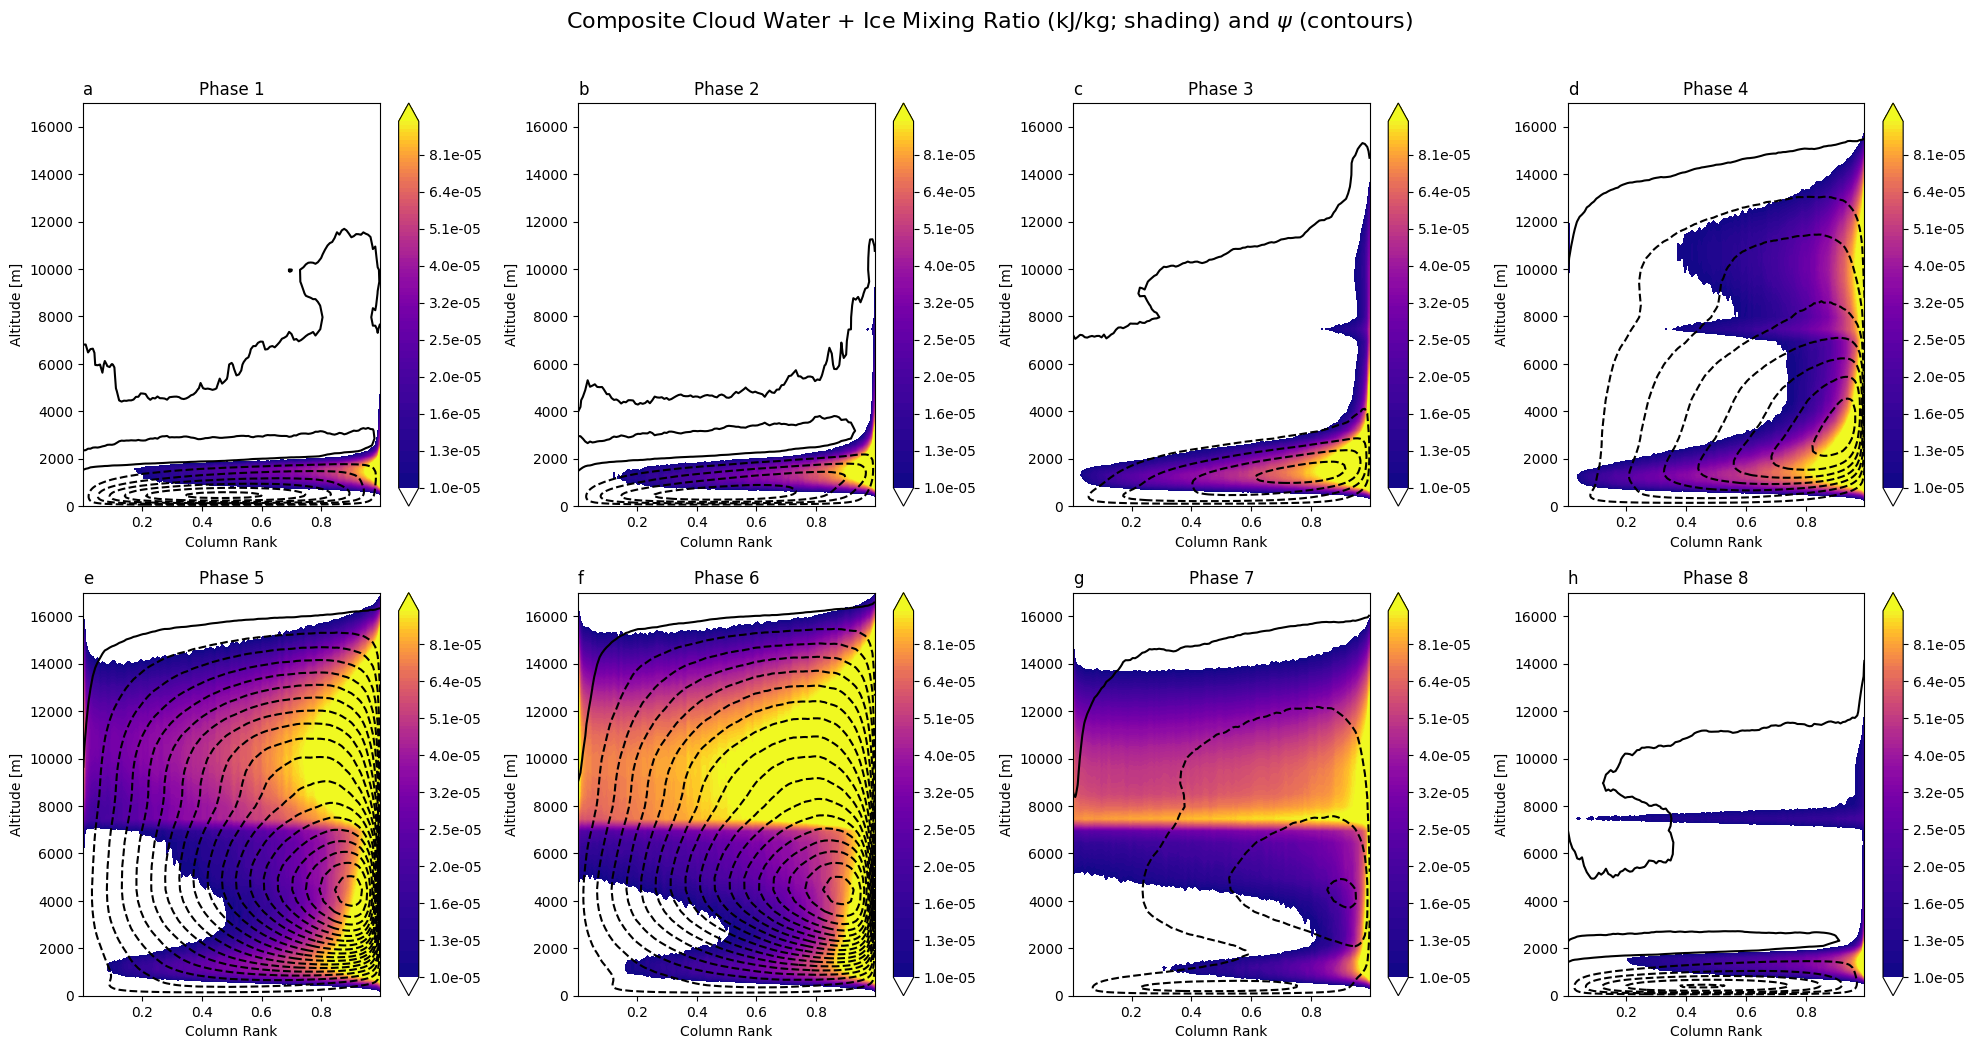

In [111]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
for i in range(1,9):
    ax = axs[np.unravel_index(i-1, axs.shape)]

   
    # QCpI plots
    qc = load_phase_composite('QC', i).QC * 1e-3 # convert to kg/kg
    qi = load_phase_composite('QI', i).QI * 1e-3 # convert to kg/kg
    qcpi = qc + qi
    qcpi = qcpi.coarsen({'column': 20}).mean()
    levels = np.logspace(-5, -4, 100)
    cmap = plt.cm.plasma.copy()
    cmap.set_under('white')
    c = qcpi.plot.contourf(ax=ax,
                      levels=levels,
                      cmap=cmap,
                      norm=colors.Normalize(vmin=levels.min(), vmax=levels.max()),
                      add_colorbar=False)

    cb = fig.colorbar(c)
    cb.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))

    # circulation plots
    circ = load_phase_composite('circulation', i).W
    circ = circ.assign_coords({'column': np.linspace(0, 1, circ.column.size)})
    circ = circ.coarsen({'column': 20}).mean()
    levels = np.linspace(-150, 0, 20)
    circ.plot.contour(ax=ax, levels=levels, colors='black')

    ax.set_ylim(0, 17e3)
    ax.set_title(f'Phase {i}')
    ax.set_title(chr(ord('a') + (i-1)), loc='left')
    ax.set_ylabel('Altitude [m]')
    ax.set_xlabel('Column Rank')

fig.tight_layout(pad=1.5)
fig.suptitle(r'Composite Cloud Water + Ice Mixing Ratio (kJ/kg; shading) and $\psi$ (contours)', y=1.05, fontsize=16)
save_figure(fig, 'phase_composites_psi_qcpi.pdf')

# Buoyancy

Text(0.5, 1.05, 'Composite $b$ [m/s2] (shading) and $\\psi$ (contours)')

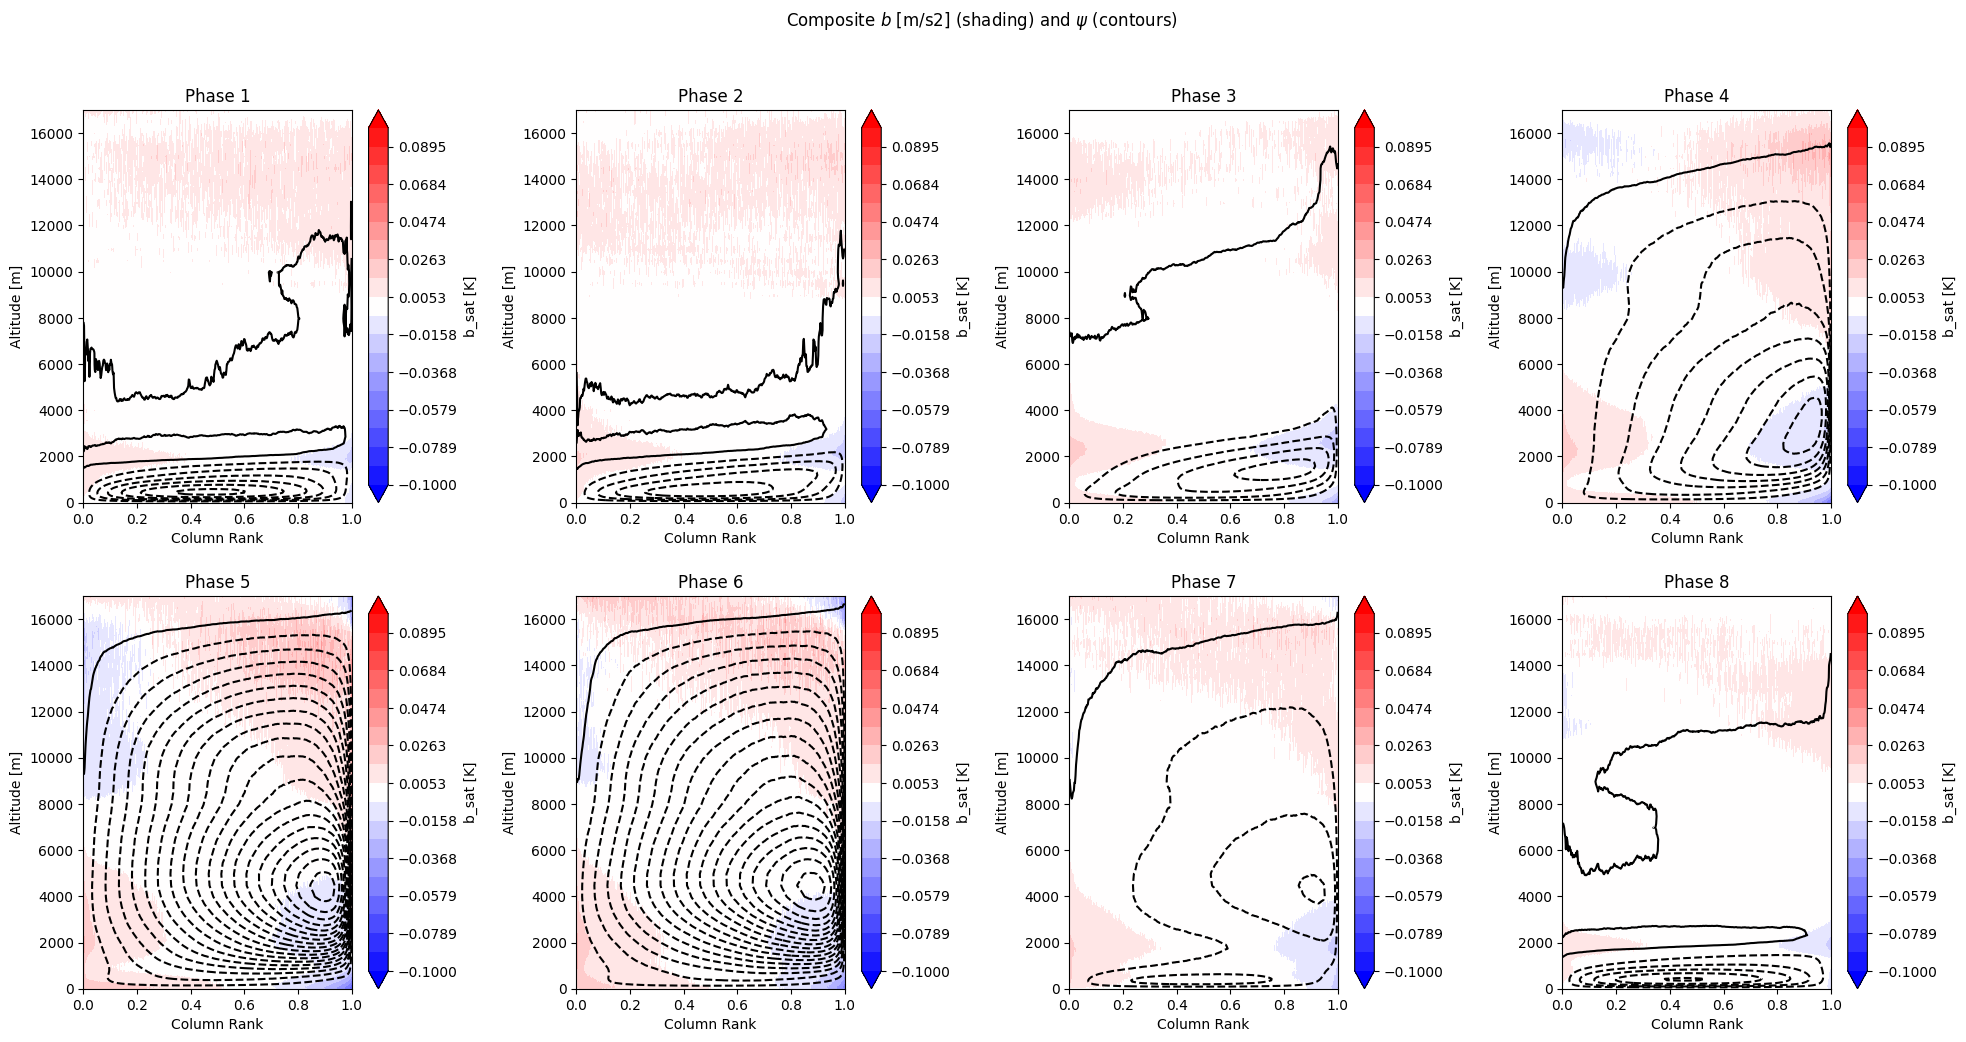

In [2]:
## Buoyancy plots
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
for i in range(1,9):
    ax = axs[np.unravel_index(i-1, axs.shape)]
    
    
    # MSE plots
    b = load_phase_composite('virtual_buoyancy', i).to_dataarray().squeeze() # in m/s2

    levels = np.linspace(-0.1, 0.1, 20)
    b.plot.contourf(ax=ax,
                    levels=levels,
                    extend='both',
                    cmap=plt.cm.bwr.copy(),
                    norm=colors.TwoSlopeNorm(vmin=levels.min(), vcenter=0, vmax=levels.max()), 
                    cbar_kwargs={'label': 'b_sat [K]'})

    # circulation plots
    circ = load_phase_composite('circulation', i).W
    circ = circ.assign_coords({'column': np.linspace(0, 1, circ.column.size)})
    circ = circ.coarsen({'column': 5}).mean()
    levels = np.linspace(-150, 0, 20)
    circ.plot.contour(ax=ax, levels=levels, colors='black')

    ax.set_ylim(0, 17e3)
    # ax.set_xlim(0.8, 1)
    
    ax.set_title(f'Phase {i}')
    ax.set_ylabel('Altitude [m]')
    ax.set_xlabel('Column Rank')
    
fig.tight_layout(pad=2)
fig.suptitle(rf'Composite $b$ [m/s2] (shading) and $\psi$ (contours)', y=1.05)
# save_figure(fig, 'phase_composites_psi_buoyancy.pdf')